In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from LTH_helper import LTH
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow_model_optimization.sparsity.keras import strip_pruning

In [10]:
my_dataset = mnist

In [11]:
results_folder = './results/'

In [12]:
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images.reshape(-1, 784)/255
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 784)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [13]:
# plt.imshow(X[0].reshape(28,28), cmap='gray')

In [14]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
  
reduce = 16

def get_model(compile_model_flag=True, lr=0.001, reduce = reduce):
    input_dim=784
    output_size = 10
#     initializer = initializers.RandomNormal(mean=0, stddev=0.1)
    initializer = initializers.glorot_normal()
    # Creo el modelo
    model = Sequential()
    model.add(Dense(784*2//reduce, activation='relu', 
                    name='hidden_1', 
                    kernel_initializer=initializer,
                    input_dim=input_dim))
    model.add(Dense(784//reduce, activation='relu', 
                    name='hidden_2', 
                    kernel_initializer=initializer))
    model.add(Dense(output_size, activation='softmax', 
                    name='Salida', input_dim=input_dim,
                    kernel_initializer=initializer))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 98)                76930     
_________________________________________________________________
hidden_2 (Dense)             (None, 49)                4851      
_________________________________________________________________
Salida (Dense)               (None, 10)                500       
Total params: 82,281
Trainable params: 82,281
Non-trainable params: 0
_________________________________________________________________


In [15]:
def get_callbacks(filename):
    return [
#         ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
    ]

In [16]:
model = get_model()
epochs = 10
batch_size = 256
# Save initial weights
model.save_weights('mlp.mnist.initial_weights.hdf5')
history = model.fit(X_train, 
           y_train,
           epochs=epochs, batch_size=batch_size, 
           validation_data = (X_val, y_val),
           verbose=2, 
           callbacks=get_callbacks('mlp.mnist.first_train.hdf5')
          )

Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.92800, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.5081 - accuracy: 0.8599 - val_loss: 0.2436 - val_accuracy: 0.9280
Epoch 2/10

Epoch 00002: val_accuracy improved from 0.92800 to 0.95033, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.2065 - accuracy: 0.9417 - val_loss: 0.1768 - val_accuracy: 0.9503
Epoch 3/10

Epoch 00003: val_accuracy improved from 0.95033 to 0.96111, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.1499 - accuracy: 0.9572 - val_loss: 0.1365 - val_accuracy: 0.9611
Epoch 4/10

Epoch 00004: val_accuracy improved from 0.96111 to 0.96422, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.1182 - accuracy: 0.9665 - val_loss: 0.1261 - val_accuracy: 0.9642
Epoch 5/10

Epoch 00005: val_accuracy improved from 0.96422 to 0.96900, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.0980 - accuracy: 0.9717 - val_loss: 0.1086 - val_

In [17]:
model.load_weights('mlp.mnist.first_train.hdf5')
model.evaluate(X_test, y_test, verbose=0)

[0.08216390013694763, 0.9753000140190125]

In [18]:
lth = LTH(get_model)

In [19]:
pms = np.linspace(0.001, 0.999, 50)
accs_nt = []
best_acc = 0

for pm in pms:
    # Devuelve el modelo pruneado en funcion del entrenamiento
    model_pruned_layers = lth.get_prunned_model('mlp.mnist.first_train.hdf5', pm)
    # Coloca los pesos iniciales en los lugares sin prunear
    model_pruned_layers_not_trained = lth.initialize_sparse_model('mlp.mnist.initial_weights.hdf5', model_pruned_layers, pm)
    actual_acc = model_pruned_layers_not_trained.evaluate(X_test, y_test, verbose=0)[1]
    print(actual_acc, pm)
    if actual_acc>best_acc:
        best_acc = actual_acc
        best_pm = pm
        model_pruned_layers_not_trained_best = strip_pruning(model_pruned_layers_not_trained)
    accs_nt.append(actual_acc)

model_pruned_layers_not_trained_best.save_weights(f'best_untrained_acc_{int(best_pm*1000)/10}_{int(best_acc*1000)/10}.hdf5')

Instructions for updating:
Please use `layer.add_weight` method instead.
0.09839999675750732 0.001
0.12860000133514404 0.02136734693877551
0.14079999923706055 0.04173469387755102
0.18039999902248383 0.06210204081632653
0.19220000505447388 0.08246938775510204
0.23759999871253967 0.10283673469387755
0.22859999537467957 0.12320408163265306
0.2754000127315521 0.14357142857142857
0.33180001378059387 0.16393877551020408
0.29739999771118164 0.1843061224489796
0.35429999232292175 0.2046734693877551
0.43059998750686646 0.2250408163265306
0.5142999887466431 0.24540816326530612
0.555899977684021 0.26577551020408163
0.5264000296592712 0.28614285714285714
0.5429999828338623 0.30651020408163265
0.619700014591217 0.32687755102040816
0.6888999938964844 0.3472448979591837
0.7127000093460083 0.3676122448979592
0.6650999784469604 0.3879795918367347
0.6241999864578247 0.4083469387755102
0.5486000180244446 0.4287142857142857
0.5734999775886536 0.4490816326530612
0.5863000154495239 0.46944897959183673
0.559

In [186]:
sample = 4
np.save(f'{results_folder}acc_not_train_prunned_10_epochs_reduce_{reduce}_normal_glorot_50_{sample}.npy', [pms, accs_nt])

In [187]:
model.summary()

Model: "sequential_2025"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 98)                76930     
_________________________________________________________________
hidden_2 (Dense)             (None, 49)                4851      
_________________________________________________________________
Salida (Dense)               (None, 10)                500       
Total params: 82,281
Trainable params: 82,281
Non-trainable params: 0
_________________________________________________________________


Text(0, 0.5, 'Accuracy')

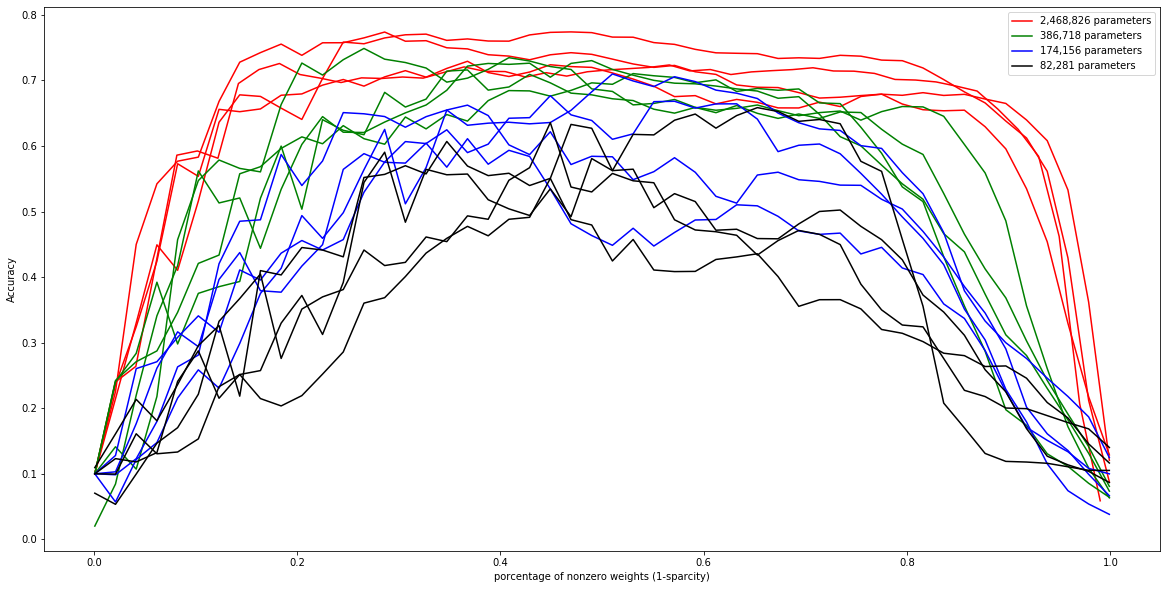

In [197]:
plt.figure(figsize=(20,10))
colors = ['r', 'g', 'b', 'k']
parameters = ['2,468,826', '386,718', '174,156', '82,281']
reduces = [1, 4, 8, 16]
for j, r in enumerate(reduces):
    for i in range(4):
        [pms, accs_nt] = np.load(f'{results_folder}acc_not_train_prunned_10_epochs_reduce_{r}_normal_glorot_50_{i+1}.npy')
        if i==0:
            plt.plot(pms, accs_nt, c=colors[j], label=f'{parameters[j]} parameters')
        else:
            plt.plot(pms, accs_nt, c=colors[j])
plt.legend()
plt.xlabel('porcentage of nonzero weights (1-sparcity)')
plt.ylabel('Accuracy')

# How the weights move

In [117]:
unpruned_trained_model = get_model()
unpruned_trained_model.load_weights('mlp.mnist.first_train.hdf5')
model_pruned_layers = lth.get_prunned_model('mlp.mnist.first_train.hdf5', None, X_train, y_train, 0.3)
untrained_model = get_model()
untrained_model.load_weights('mlp.mnist.initial_weights.hdf5')

In [118]:
n_layer = 2
mask_l1 = model_pruned_layers.layers[n_layer].pruning_vars[0][1].numpy()
weights_l1 = unpruned_trained_model.layers[n_layer].get_weights()[0]
init_weights_l1 = untrained_model.layers[n_layer].get_weights()[0]

In [119]:
print('Movimiento de los no pruneados:\t', ((weights_l1 - init_weights_l1)*mask_l1).std())
print('Movimiento de los pruneados:\t',((weights_l1 - init_weights_l1)*(1-mask_l1)).std())

Movimiento de los no pruneados:	 0.018372707
Movimiento de los pruneados:	 0.015532026
